#          **Virtual Real Person Control (Mimico)**

---



---



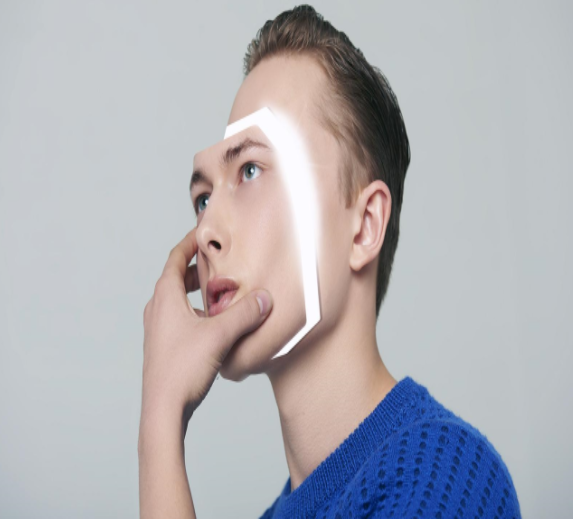





### **open the drive to get the code** 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 **install Ffmpy** 

In [2]:
!pip install ffmpy &> /dev/null

Set the path of project

In [3]:
cd /content/drive/MyDrive/Virtual Real Person Control (Mimico)

/content/drive/MyDrive/Virtual Real Person Control (Mimico)



## **Upload source image and driving video**

In [4]:
import IPython.display
import PIL.Image
import cv2
import imageio
import io
import ipywidgets
import numpy
import os.path
import requests
import skimage.transform
import warnings
from base64 import b64encode
from demo import load_checkpoints, make_animation
from ffmpy import FFmpeg
from google.colab import files, output
from IPython.display import HTML, Javascript
from skimage import img_as_ubyte
warnings.filterwarnings("ignore")
os.makedirs("user", exist_ok=True)

display(HTML("""
<style>
.widget-box > * {
	flex-shrink: 0;
  background-color:black;
}
.widget-tab {
	min-width: 0;
	flex: 1 1 auto;
}
.widget-tab .p-TabBar-tabLabel {
	font-size: 15px;
}
.widget-upload {
	background-color: tan;
}
.widget-button {
	font-size: 18px;
	width: 160px;
	height: 34px;
	line-height: 34px;
}
.widget-dropdown {
	width: 250px;
}
.widget-checkbox {
    width: 650px;
}
.widget-checkbox + .widget-checkbox {
    margin-top: -6px;
}
.input-widget .output_html {
	text-align: center;
	width: 266px;
	height: 266px;
	line-height: 266px;
	color: lightgray;
	font-size: 72px;
}
div.stream {
	display: none;
}
.title {
	font-size: 20px;
	font-weight: bold;
	margin: 12px 0 6px 0;
}
.warning {
	display: none;
	color: red;
	margin-left: 10px;
}
.warn {
	display: initial;
}
.resource {
	cursor: pointer;
	border: 1px solid gray;
	margin: 5px;
	width: 160px;
	height: 160px;
	min-width: 160px;
	min-height: 160px;
	max-width: 160px;
	max-height: 160px;
	-webkit-box-sizing: initial;
	box-sizing: initial;
}
.resource:hover {
	border: 6px solid crimson;
	margin: 0;
}
.selected {
	border: 6px solid seagreen;
	margin: 0;
}
.input-widget {
	width: 266px;
	height: 266px;
	border: 1px solid gray;
}
.input-button {
	width: 268px;
	font-size: 15px;
	margin: 2px 0 0;
}
.output-widget {
	width: 256px;
	height: 256px;
	border: 1px solid gray;
}
.output-button {
	width: 258px;
	font-size: 15px;
	margin: 2px 0 0;
}
.uploaded {
	width: 256px;
	height: 256px;
	border: 6px solid seagreen;
	margin: 0;
}
.label-or {
	align-self: center;
	font-size: 20px;
	margin: 16px;
}
.loading {
	align-items: center;
	width: fit-content;
}
.loader {
	margin: 32px 0 16px 0;
	width: 48px;
	height: 48px;
	min-width: 48px;
	min-height: 48px;
	max-width: 48px;
	max-height: 48px;
	border: 4px solid whitesmoke;
	border-top-color: gray;
	border-radius: 50%;
	animation: spin 1.8s linear infinite;
}
.loading-label {
	color: gray;
}
.comparison-widget {
	width: 256px;
	height: 256px;
	border: 1px solid gray;
	margin-left: 2px;
}
.comparison-label {
	color: gray;
	font-size: 14px;
	text-align: center;
	position: relative;
	bottom: 3px;
}
@keyframes spin {
	from { transform: rotate(0deg); }
	to { transform: rotate(360deg); }
}
</style>
"""))

def thumbnail(file):
	return imageio.get_reader(file, mode='I', format='FFMPEG').get_next_data()


def create_title(title):
	title_widget = ipywidgets.Label(title)
	title_widget.add_class('title')
	return title_widget

def download_output(button):
	complete.layout.display = 'none'
	loading.layout.display = ''
	files.download('output.mp4')
	loading.layout.display = 'none'
	complete.layout.display = ''

def convert_output(button):
	complete.layout.display = 'none'
	loading.layout.display = ''
	FFmpeg(inputs={'output.mp4': None}, outputs={'scaled.mp4': '-vf "scale=1080x1080:flags=lanczos,pad=1920:1080:420:0" -y'}).run()
	files.download('scaled.mp4')
	loading.layout.display = 'none'
	complete.layout.display = ''

def back_to_main(button):
	complete.layout.display = 'none'
	main.layout.display = ''

label_or = ipywidgets.Label('or')
label_or.add_class('label-or')

image_titles = ['Face']
	
image_lengths = [1]


input_image_widget = ipywidgets.Output()
input_image_widget.add_class('input-widget')
upload_input_image_button = ipywidgets.FileUpload(accept='image/*', button_style='primary')
upload_input_image_button.style.button_color = 'lightgreen'
upload_input_image_button.add_class('input-button')
image_part = ipywidgets.HBox([
	ipywidgets.VBox([input_image_widget, upload_input_image_button]),
	label_or
])


input_video_widget = ipywidgets.Output()
input_video_widget.add_class('input-widget')
upload_input_video_button = ipywidgets.FileUpload(accept='video/*', button_style='primary')
upload_input_image_button.style.button_color = 'lightgreen'
upload_input_video_button.add_class('input-button')
video_part = ipywidgets.HBox([
	ipywidgets.VBox([input_video_widget, upload_input_video_button]),
	label_or
])

model = ipywidgets.Dropdown(
	description="Model:",
	options=[
		'vox-adv',
		'taichi-adv'
		
	]
)
warning = ipywidgets.HTML('<b>Warning:</b> Upload your own images and videos (see README)')
warning.add_class('warning')
model_part = ipywidgets.HBox([model, warning])

generate_button = ipywidgets.Button(description="Generate", button_style='primary')
main = ipywidgets.VBox([
	create_title('Choose Image'),
	image_part,
	create_title('Choose Video'),
	video_part,
	create_title('Settings'),
	model_part,
	generate_button
])

loader = ipywidgets.Label()
loader.add_class("loader")
loading_label = ipywidgets.Label("This may take several minutes to process…")
loading_label.add_class("loading-label")
loading = ipywidgets.VBox([loader, loading_label])
loading.add_class('loading')

output_widget = ipywidgets.Output()
output_widget.add_class('output-widget')
download = ipywidgets.Button(description='Download', button_style='primary')
download.add_class('output-button')
download.on_click(download_output)
convert = ipywidgets.Button(description='Convert to 1920×1080', button_style='primary')
convert.add_class('output-button')
convert.on_click(convert_output)
back = ipywidgets.Button(description='Back', button_style='primary')
back.add_class('output-button')
back.on_click(back_to_main)

comparison_widget = ipywidgets.Output()
comparison_widget.add_class('comparison-widget')
comparison_label = ipywidgets.Label('Comparison')
comparison_label.add_class('comparison-label')
complete = ipywidgets.HBox([
	ipywidgets.VBox([output_widget, download, convert, back]),
	ipywidgets.VBox([comparison_widget, comparison_label])
])

display(ipywidgets.VBox([main, loading, complete]))
display(Javascript("""
var images, videos;
function deselectImages() {
	images.forEach(function(item) {
		item.classList.remove("selected");
	});
}
function deselectVideos() {
	videos.forEach(function(item) {
		item.classList.remove("selected");
	});
}
function invokePython(func) {
	google.colab.kernel.invokeFunction("notebook." + func, [].slice.call(arguments, 1), {});
}
setTimeout(function() {
	(images = [].slice.call(document.getElementsByClassName("resource-image"))).forEach(function(item) {
		item.addEventListener("click", function() {
			deselectImages();
			item.classList.add("selected");
			invokePython("select_image", item.className.match(/resource-image(\d\d)/)[1]);
		});
	});
	images[0].classList.add("selected");
	(videos = [].slice.call(document.getElementsByClassName("resource-video"))).forEach(function(item) {
		item.addEventListener("click", function() {
			deselectVideos();
			item.classList.add("selected");
			invokePython("select_video", item.className.match(/resource-video(\d)/)[1]);
		});
	});
	videos[0].classList.add("selected");
}, 1000);
"""))


def resize(image, size=(256, 256)):
    w, h = image.size
    d = min(w, h)
    r = ((w - d) // 2, (h - d) // 2, (w + d) // 2, (h + d) // 2)
    return image.resize(size, resample=PIL.Image.LANCZOS, box=r)

def upload_image(change):
	global selected_image
	for name, file_info in upload_input_image_button.value.items():
		content = file_info['content']
	if content is not None:
		selected_image = resize(PIL.Image.open(io.BytesIO(content)).convert("RGB"))
		input_image_widget.clear_output(wait=True)
		with input_image_widget:
			display(selected_image)
		input_image_widget.add_class('uploaded')
		display(Javascript('deselectImages()'))
upload_input_image_button.observe(upload_image, names='value')

def upload_video(change):
	global selected_video
	for name, file_info in upload_input_video_button.value.items():
		content = file_info['content']
	if content is not None:
		selected_video = 'user/' + name
		preview = resize(PIL.Image.fromarray(thumbnail(content)).convert("RGB"))
		input_video_widget.clear_output(wait=True)
		with input_video_widget:
			display(preview)
		input_video_widget.add_class('uploaded')
		display(Javascript('deselectVideos()'))
		with open(selected_video, 'wb') as video:
			video.write(content)
upload_input_video_button.observe(upload_video, names='value')

def change_model(change):
	if model.value.startswith('vox'):
		warning.remove_class('warn')
	else:
		warning.add_class('warn')
model.observe(change_model, names='value')

def generate(button):
	main.layout.display = 'none'
	loading.layout.display = ''
	filename = model.value +'-cpk.pth.tar'
	if not os.path.isfile(filename):
		download = requests.get(requests.get('https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key=https://yadi.sk/d/lEw8uRm140L_eQ&path=/' + filename).json().get('href'))
		with open(filename, 'wb') as checkpoint:
			checkpoint.write(download.content)
	reader = imageio.get_reader(selected_video, mode='I', format='FFMPEG')
	fps = reader.get_meta_data()['fps']
	driving_video = []
	for frame in reader:
		driving_video.append(frame)
	generator, kp_detector = load_checkpoints(config_path='config/%s-256.yaml' % model.value, checkpoint_path=filename)
	predictions = make_animation(
		skimage.transform.resize(numpy.asarray(selected_image), (256, 256)),
		[skimage.transform.resize(frame, (256, 256)) for frame in driving_video],
		generator,
		kp_detector
	)
	imageio.mimsave('output.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)
	loading.layout.display = 'none'
	complete.layout.display = ''
	with output_widget:
		display(HTML('<video id="left" controls src="data:video/mp4;base64,%s" />' % b64encode(open('output.mp4', 'rb').read()).decode()))
	with comparison_widget:
		display(HTML('<video id="right" muted src="data:video/mp4;base64,%s" />' % b64encode(open(selected_video, 'rb').read()).decode()))
	display(Javascript("""
	(function(left, right) {
		left.addEventListener("play", function() {
			right.play();
		});
		left.addEventListener("pause", function() {
			right.pause();
		});
		left.addEventListener("seeking", function() {
			right.currentTime = left.currentTime;
		});
	})(document.getElementById("left"), document.getElementById("right"));
	"""))
	
generate_button.on_click(generate)

loading.layout.display = 'none'
complete.layout.display = 'none'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  1%|▏         | 3/211 [00:00<00:35,  5.87it/s]

tensor([[[[9.9980e-01, 9.9946e-01, 9.9976e-01,  ..., 9.9594e-01,
           9.9466e-01, 9.9810e-01],
          [9.9978e-01, 9.9746e-01, 9.9816e-01,  ..., 9.6638e-01,
           9.7216e-01, 9.9708e-01],
          [9.9971e-01, 9.9460e-01, 9.9614e-01,  ..., 9.4162e-01,
           9.4730e-01, 9.9588e-01],
          ...,
          [8.7412e-01, 7.2453e-01, 7.4270e-01,  ..., 8.2580e-01,
           8.2585e-01, 9.3069e-01],
          [8.5580e-01, 6.8962e-01, 6.7949e-01,  ..., 8.2805e-01,
           8.5796e-01, 9.2868e-01],
          [8.5597e-01, 7.3961e-01, 7.1719e-01,  ..., 8.6227e-01,
           8.8144e-01, 9.0371e-01]],

         [[5.8572e-07, 8.8995e-08, 2.5088e-08,  ..., 2.3977e-06,
           3.6561e-06, 1.3606e-06],
          [2.3442e-07, 9.9413e-08, 2.7569e-08,  ..., 1.3205e-05,
           1.0120e-05, 9.1080e-07],
          [2.6406e-07, 3.1392e-07, 9.2055e-08,  ..., 9.3595e-05,
           6.9394e-05, 3.0285e-06],
          ...,
          [2.9247e-03, 2.9380e-03, 3.0826e-03,  ..., 2.0904

  2%|▏         | 5/211 [00:00<00:27,  7.36it/s]

tensor([[[[9.9986e-01, 9.9947e-01, 9.9972e-01,  ..., 9.9989e-01,
           9.9971e-01, 9.9968e-01],
          [9.9983e-01, 9.9715e-01, 9.9708e-01,  ..., 9.9901e-01,
           9.9849e-01, 9.9948e-01],
          [9.9976e-01, 9.9344e-01, 9.9342e-01,  ..., 9.9804e-01,
           9.9730e-01, 9.9943e-01],
          ...,
          [8.6108e-01, 6.3273e-01, 6.1508e-01,  ..., 4.6946e-01,
           5.4659e-01, 7.6650e-01],
          [8.5078e-01, 6.1091e-01, 5.5024e-01,  ..., 4.6344e-01,
           5.8806e-01, 7.8822e-01],
          [8.5475e-01, 6.8469e-01, 6.1602e-01,  ..., 5.8901e-01,
           6.9922e-01, 8.0315e-01]],

         [[2.3056e-07, 4.0165e-08, 2.4248e-08,  ..., 1.5547e-09,
           4.3331e-09, 1.3297e-08],
          [8.0672e-08, 4.2571e-08, 3.1929e-08,  ..., 1.4736e-09,
           1.9981e-09, 1.9536e-09],
          [9.6755e-08, 1.3769e-07, 1.1435e-07,  ..., 4.7265e-09,
           4.6223e-09, 1.8280e-09],
          ...,
          [1.7416e-03, 1.3980e-03, 1.7092e-03,  ..., 4.3217

  5%|▌         | 11/211 [00:00<00:17, 11.18it/s]

tensor([[[[9.9995e-01, 9.9985e-01, 9.9995e-01,  ..., 9.9997e-01,
           9.9991e-01, 9.9984e-01],
          [9.9996e-01, 9.9946e-01, 9.9964e-01,  ..., 9.9980e-01,
           9.9962e-01, 9.9977e-01],
          [9.9995e-01, 9.9884e-01, 9.9929e-01,  ..., 9.9963e-01,
           9.9939e-01, 9.9977e-01],
          ...,
          [8.7297e-01, 6.3398e-01, 6.1028e-01,  ..., 5.9780e-01,
           6.5194e-01, 8.4411e-01],
          [8.5816e-01, 6.0824e-01, 5.4596e-01,  ..., 5.8865e-01,
           6.9529e-01, 8.6136e-01],
          [8.5849e-01, 6.8541e-01, 6.1475e-01,  ..., 6.9244e-01,
           7.7800e-01, 8.6011e-01]],

         [[4.4112e-08, 3.0457e-09, 1.1322e-09,  ..., 1.3805e-10,
           4.7349e-10, 2.4919e-09],
          [8.4303e-09, 1.5103e-09, 6.3310e-10,  ..., 6.6543e-11,
           1.0718e-10, 2.1359e-10],
          [6.9390e-09, 3.4735e-09, 1.6320e-09,  ..., 1.7373e-10,
           1.8744e-10, 1.6432e-10],
          ...,
          [1.4509e-03, 1.3021e-03, 1.4869e-03,  ..., 1.9313

  8%|▊         | 17/211 [00:01<00:12, 15.04it/s]

tensor([[[[9.9993e-01, 9.9979e-01, 9.9992e-01,  ..., 9.9998e-01,
           9.9992e-01, 9.9986e-01],
          [9.9994e-01, 9.9911e-01, 9.9934e-01,  ..., 9.9985e-01,
           9.9971e-01, 9.9981e-01],
          [9.9992e-01, 9.9802e-01, 9.9861e-01,  ..., 9.9973e-01,
           9.9953e-01, 9.9980e-01],
          ...,
          [8.5415e-01, 6.1553e-01, 5.9546e-01,  ..., 6.5066e-01,
           7.0229e-01, 8.7809e-01],
          [8.3644e-01, 5.8700e-01, 5.3135e-01,  ..., 6.5505e-01,
           7.5419e-01, 8.9295e-01],
          [8.4075e-01, 6.6917e-01, 6.0461e-01,  ..., 7.4965e-01,
           8.2348e-01, 8.8630e-01]],

         [[6.9256e-08, 6.1600e-09, 2.6556e-09,  ..., 9.2580e-11,
           3.1931e-10, 1.7317e-09],
          [1.5330e-08, 3.7234e-09, 1.8987e-09,  ..., 4.0364e-11,
           6.4984e-11, 1.3673e-10],
          [1.3584e-08, 9.3061e-09, 5.3777e-09,  ..., 1.0908e-10,
           1.1675e-10, 1.0925e-10],
          ...,
          [1.7866e-03, 1.5320e-03, 1.6782e-03,  ..., 1.6721

 11%|█         | 23/211 [00:01<00:10, 18.12it/s]

tensor([[[[9.9989e-01, 9.9964e-01, 9.9985e-01,  ..., 9.9997e-01,
           9.9990e-01, 9.9984e-01],
          [9.9989e-01, 9.9831e-01, 9.9871e-01,  ..., 9.9980e-01,
           9.9961e-01, 9.9978e-01],
          [9.9984e-01, 9.9603e-01, 9.9707e-01,  ..., 9.9963e-01,
           9.9937e-01, 9.9977e-01],
          ...,
          [8.5745e-01, 6.3312e-01, 6.2368e-01,  ..., 6.8893e-01,
           7.1995e-01, 8.8880e-01],
          [8.3982e-01, 6.0383e-01, 5.5838e-01,  ..., 6.8814e-01,
           7.6635e-01, 8.9933e-01],
          [8.4331e-01, 6.7982e-01, 6.2159e-01,  ..., 7.6681e-01,
           8.2789e-01, 8.8872e-01]],

         [[1.3795e-07, 1.5994e-08, 6.9846e-09,  ..., 1.6911e-10,
           5.6373e-10, 2.5203e-09],
          [3.7172e-08, 1.2154e-08, 6.2110e-09,  ..., 8.9553e-11,
           1.3922e-10, 2.2711e-10],
          [3.7379e-08, 3.4462e-08, 1.9635e-08,  ..., 2.5706e-10,
           2.7532e-10, 1.9377e-10],
          ...,
          [1.7179e-03, 1.4386e-03, 1.5031e-03,  ..., 1.5014

 12%|█▏        | 26/211 [00:01<00:09, 19.15it/s]

tensor([[[[9.9989e-01, 9.9963e-01, 9.9985e-01,  ..., 9.9994e-01,
           9.9983e-01, 9.9977e-01],
          [9.9988e-01, 9.9828e-01, 9.9873e-01,  ..., 9.9960e-01,
           9.9931e-01, 9.9968e-01],
          [9.9983e-01, 9.9590e-01, 9.9707e-01,  ..., 9.9927e-01,
           9.9886e-01, 9.9966e-01],
          ...,
          [8.2904e-01, 5.7966e-01, 5.6652e-01,  ..., 6.4537e-01,
           6.8115e-01, 8.6606e-01],
          [8.1439e-01, 5.5705e-01, 5.0572e-01,  ..., 6.4351e-01,
           7.2925e-01, 8.8027e-01],
          [8.2618e-01, 6.4512e-01, 5.7353e-01,  ..., 7.2612e-01,
           7.9700e-01, 8.7174e-01]],

         [[1.3210e-07, 1.4520e-08, 5.8662e-09,  ..., 5.0483e-10,
           1.4912e-09, 5.2867e-09],
          [3.5276e-08, 1.0800e-08, 4.9046e-09,  ..., 3.0832e-10,
           4.3966e-10, 5.5209e-10],
          [3.6493e-08, 3.1530e-08, 1.5613e-08,  ..., 8.6292e-10,
           8.8999e-10, 4.8504e-10],
          ...,
          [1.9823e-03, 1.6028e-03, 1.6775e-03,  ..., 1.7702

 15%|█▌        | 32/211 [00:01<00:08, 20.75it/s]

tensor([[[[9.9992e-01, 9.9976e-01, 9.9991e-01,  ..., 9.9994e-01,
           9.9984e-01, 9.9978e-01],
          [9.9992e-01, 9.9890e-01, 9.9924e-01,  ..., 9.9961e-01,
           9.9933e-01, 9.9968e-01],
          [9.9989e-01, 9.9741e-01, 9.9826e-01,  ..., 9.9927e-01,
           9.9887e-01, 9.9967e-01],
          ...,
          [7.9479e-01, 5.3285e-01, 5.2266e-01,  ..., 5.7227e-01,
           6.1859e-01, 8.2630e-01],
          [7.8191e-01, 5.1681e-01, 4.6898e-01,  ..., 5.7068e-01,
           6.6868e-01, 8.4764e-01],
          [8.0093e-01, 6.1196e-01, 5.4084e-01,  ..., 6.8201e-01,
           7.6372e-01, 8.5116e-01]],

         [[8.3937e-08, 7.2184e-09, 2.5005e-09,  ..., 4.5163e-10,
           1.3514e-09, 4.9915e-09],
          [2.0595e-08, 4.8749e-09, 1.9120e-09,  ..., 2.7877e-10,
           4.0165e-10, 5.2270e-10],
          [1.9853e-08, 1.3581e-08, 5.9684e-09,  ..., 8.4379e-10,
           8.5448e-10, 4.7255e-10],
          ...,
          [2.2198e-03, 1.7522e-03, 1.7888e-03,  ..., 1.9994

 18%|█▊        | 38/211 [00:01<00:07, 21.72it/s]

tensor([[[[9.9992e-01, 9.9978e-01, 9.9992e-01,  ..., 9.9994e-01,
           9.9983e-01, 9.9977e-01],
          [9.9991e-01, 9.9889e-01, 9.9929e-01,  ..., 9.9957e-01,
           9.9926e-01, 9.9968e-01],
          [9.9986e-01, 9.9712e-01, 9.9820e-01,  ..., 9.9917e-01,
           9.9874e-01, 9.9965e-01],
          ...,
          [8.0508e-01, 5.4533e-01, 5.2817e-01,  ..., 5.3246e-01,
           6.0540e-01, 8.1522e-01],
          [7.9555e-01, 5.3003e-01, 4.7529e-01,  ..., 5.4916e-01,
           6.6849e-01, 8.4580e-01],
          [8.1222e-01, 6.2390e-01, 5.5055e-01,  ..., 6.7905e-01,
           7.7240e-01, 8.5584e-01]],

         [[9.8308e-08, 6.6487e-09, 2.1197e-09,  ..., 5.3961e-10,
           1.5248e-09, 4.7156e-09],
          [2.8993e-08, 5.1425e-09, 1.8487e-09,  ..., 3.4404e-10,
           4.5515e-10, 4.8324e-10],
          [3.2997e-08, 1.7156e-08, 7.2956e-09,  ..., 1.1995e-09,
           1.0755e-09, 4.7112e-10],
          ...,
          [2.1917e-03, 1.7314e-03, 1.9122e-03,  ..., 2.3092

 19%|█▉        | 41/211 [00:02<00:07, 21.88it/s]

tensor([[[[9.9987e-01, 9.9963e-01, 9.9986e-01,  ..., 9.9986e-01,
           9.9966e-01, 9.9968e-01],
          [9.9982e-01, 9.9795e-01, 9.9867e-01,  ..., 9.9884e-01,
           9.9835e-01, 9.9954e-01],
          [9.9970e-01, 9.9435e-01, 9.9633e-01,  ..., 9.9766e-01,
           9.9693e-01, 9.9949e-01],
          ...,
          [8.3686e-01, 5.9813e-01, 5.7972e-01,  ..., 6.4747e-01,
           6.9824e-01, 8.6934e-01],
          [8.2585e-01, 5.7252e-01, 5.1235e-01,  ..., 6.6797e-01,
           7.6067e-01, 8.9171e-01],
          [8.3552e-01, 6.5810e-01, 5.8618e-01,  ..., 7.6427e-01,
           8.3192e-01, 8.8869e-01]],

         [[2.4737e-07, 1.9833e-08, 6.1368e-09,  ..., 2.4727e-09,
           5.5887e-09, 9.9527e-09],
          [8.9583e-08, 1.8620e-08, 6.5297e-09,  ..., 2.6381e-09,
           2.6894e-09, 1.3531e-09],
          [1.1086e-07, 6.4706e-08, 2.7129e-08,  ..., 1.2108e-08,
           8.5324e-09, 1.6000e-09],
          ...,
          [1.9141e-03, 1.4858e-03, 1.6963e-03,  ..., 2.0171

 22%|██▏       | 47/211 [00:02<00:07, 22.10it/s]

tensor([[[[9.9988e-01, 9.9964e-01, 9.9986e-01,  ..., 9.9992e-01,
           9.9979e-01, 9.9975e-01],
          [9.9985e-01, 9.9814e-01, 9.9874e-01,  ..., 9.9941e-01,
           9.9906e-01, 9.9965e-01],
          [9.9977e-01, 9.9520e-01, 9.9680e-01,  ..., 9.9887e-01,
           9.9836e-01, 9.9962e-01],
          ...,
          [8.1004e-01, 5.4458e-01, 5.2304e-01,  ..., 5.4458e-01,
           6.1548e-01, 8.2077e-01],
          [7.9744e-01, 5.2516e-01, 4.6381e-01,  ..., 5.6469e-01,
           6.8225e-01, 8.5292e-01],
          [8.1519e-01, 6.2326e-01, 5.4418e-01,  ..., 6.9223e-01,
           7.8273e-01, 8.6133e-01]],

         [[1.9344e-07, 1.7545e-08, 6.0395e-09,  ..., 8.8288e-10,
           2.2193e-09, 5.6653e-09],
          [5.8835e-08, 1.4108e-08, 5.5449e-09,  ..., 6.5128e-10,
           7.6005e-10, 6.2535e-10],
          [6.3863e-08, 4.2491e-08, 1.9270e-08,  ..., 2.3579e-09,
           1.8805e-09, 6.2045e-10],
          ...,
          [2.2228e-03, 1.8593e-03, 2.1213e-03,  ..., 2.5469

 25%|██▌       | 53/211 [00:02<00:07, 22.41it/s]

tensor([[[[9.9988e-01, 9.9962e-01, 9.9985e-01,  ..., 9.9993e-01,
           9.9981e-01, 9.9977e-01],
          [9.9985e-01, 9.9809e-01, 9.9869e-01,  ..., 9.9950e-01,
           9.9916e-01, 9.9968e-01],
          [9.9977e-01, 9.9513e-01, 9.9674e-01,  ..., 9.9904e-01,
           9.9854e-01, 9.9966e-01],
          ...,
          [8.1980e-01, 5.6056e-01, 5.4737e-01,  ..., 6.4478e-01,
           6.8910e-01, 8.6577e-01],
          [8.0797e-01, 5.4359e-01, 4.8916e-01,  ..., 6.6252e-01,
           7.5083e-01, 8.8898e-01],
          [8.2135e-01, 6.3475e-01, 5.6049e-01,  ..., 7.5778e-01,
           8.2567e-01, 8.8661e-01]],

         [[1.8143e-07, 1.6535e-08, 5.6904e-09,  ..., 6.5263e-10,
           1.7473e-09, 4.9005e-09],
          [5.3556e-08, 1.2800e-08, 4.9615e-09,  ..., 4.4634e-10,
           5.6150e-10, 5.1429e-10],
          [5.7481e-08, 3.7732e-08, 1.6529e-08,  ..., 1.5688e-09,
           1.3636e-09, 4.9384e-10],
          ...,
          [2.0284e-03, 1.6970e-03, 1.8867e-03,  ..., 1.9566

 27%|██▋       | 56/211 [00:02<00:06, 22.48it/s]

tensor([[[[9.9990e-01, 9.9972e-01, 9.9990e-01,  ..., 9.9995e-01,
           9.9986e-01, 9.9980e-01],
          [9.9989e-01, 9.9864e-01, 9.9908e-01,  ..., 9.9968e-01,
           9.9943e-01, 9.9973e-01],
          [9.9984e-01, 9.9666e-01, 9.9782e-01,  ..., 9.9940e-01,
           9.9906e-01, 9.9972e-01],
          ...,
          [7.9461e-01, 5.1594e-01, 4.9872e-01,  ..., 5.2763e-01,
           6.0345e-01, 8.1553e-01],
          [7.8302e-01, 5.0114e-01, 4.4478e-01,  ..., 5.4793e-01,
           6.7190e-01, 8.4966e-01],
          [8.0726e-01, 6.0836e-01, 5.3079e-01,  ..., 6.7791e-01,
           7.7505e-01, 8.5885e-01]],

         [[1.2433e-07, 1.0207e-08, 3.4860e-09,  ..., 3.8725e-10,
           1.0674e-09, 3.7084e-09],
          [3.3491e-08, 7.1979e-09, 2.7695e-09,  ..., 2.2083e-10,
           2.8874e-10, 3.5590e-10],
          [3.3839e-08, 2.0221e-08, 8.7738e-09,  ..., 6.8164e-10,
           6.0801e-10, 3.1644e-10],
          ...,
          [2.1067e-03, 1.6691e-03, 1.8246e-03,  ..., 2.2957

 29%|██▉       | 62/211 [00:03<00:06, 22.33it/s]

tensor([[[[9.9990e-01, 9.9971e-01, 9.9989e-01,  ..., 9.9991e-01,
           9.9976e-01, 9.9972e-01],
          [9.9989e-01, 9.9859e-01, 9.9905e-01,  ..., 9.9940e-01,
           9.9904e-01, 9.9962e-01],
          [9.9983e-01, 9.9629e-01, 9.9754e-01,  ..., 9.9892e-01,
           9.9843e-01, 9.9960e-01],
          ...,
          [7.8740e-01, 5.0569e-01, 4.8516e-01,  ..., 4.7239e-01,
           5.5037e-01, 7.7662e-01],
          [7.7592e-01, 4.9257e-01, 4.3379e-01,  ..., 4.9130e-01,
           6.1646e-01, 8.1428e-01],
          [7.9687e-01, 5.9359e-01, 5.1413e-01,  ..., 6.3517e-01,
           7.3923e-01, 8.3481e-01]],

         [[1.0857e-07, 8.6944e-09, 2.9712e-09,  ..., 8.5649e-10,
           2.2231e-09, 6.3061e-09],
          [2.9346e-08, 6.2756e-09, 2.4464e-09,  ..., 4.9470e-10,
           6.1208e-10, 6.2275e-10],
          [3.1800e-08, 1.9798e-08, 9.0294e-09,  ..., 1.3872e-09,
           1.1905e-09, 5.2889e-10],
          ...,
          [2.5850e-03, 2.2645e-03, 2.6249e-03,  ..., 2.9069

 32%|███▏      | 68/211 [00:03<00:06, 22.43it/s]

tensor([[[[9.9992e-01, 9.9975e-01, 9.9991e-01,  ..., 9.9992e-01,
           9.9979e-01, 9.9971e-01],
          [9.9991e-01, 9.9885e-01, 9.9923e-01,  ..., 9.9953e-01,
           9.9922e-01, 9.9961e-01],
          [9.9986e-01, 9.9702e-01, 9.9809e-01,  ..., 9.9921e-01,
           9.9883e-01, 9.9960e-01],
          ...,
          [7.9847e-01, 5.0861e-01, 4.8707e-01,  ..., 4.9787e-01,
           5.8540e-01, 8.0736e-01],
          [7.9114e-01, 4.9911e-01, 4.3457e-01,  ..., 5.1537e-01,
           6.5043e-01, 8.3983e-01],
          [8.1350e-01, 6.0660e-01, 5.1868e-01,  ..., 6.5048e-01,
           7.5719e-01, 8.4984e-01]],

         [[8.5548e-08, 6.0594e-09, 2.0584e-09,  ..., 7.9131e-10,
           2.0784e-09, 7.2402e-09],
          [2.1289e-08, 3.9533e-09, 1.5041e-09,  ..., 4.0389e-10,
           5.2053e-10, 7.1776e-10],
          [2.1815e-08, 1.1832e-08, 5.1740e-09,  ..., 9.9347e-10,
           8.8599e-10, 5.8052e-10],
          ...,
          [2.0191e-03, 1.6737e-03, 1.9358e-03,  ..., 2.4670

 34%|███▎      | 71/211 [00:03<00:06, 22.37it/s]

tensor([[[[9.9993e-01, 9.9980e-01, 9.9993e-01,  ..., 9.9995e-01,
           9.9986e-01, 9.9980e-01],
          [9.9993e-01, 9.9913e-01, 9.9943e-01,  ..., 9.9969e-01,
           9.9945e-01, 9.9973e-01],
          [9.9989e-01, 9.9776e-01, 9.9859e-01,  ..., 9.9944e-01,
           9.9914e-01, 9.9972e-01],
          ...,
          [7.9712e-01, 5.1840e-01, 5.0390e-01,  ..., 5.6104e-01,
           6.3119e-01, 8.3261e-01],
          [7.9220e-01, 5.0984e-01, 4.5286e-01,  ..., 5.8460e-01,
           7.0167e-01, 8.6626e-01],
          [8.1665e-01, 6.1466e-01, 5.3464e-01,  ..., 7.0754e-01,
           7.9735e-01, 8.7324e-01]],

         [[6.7889e-08, 4.0859e-09, 1.3004e-09,  ..., 3.0279e-10,
           8.5392e-10, 3.2298e-09],
          [1.5741e-08, 2.4208e-09, 8.7841e-10,  ..., 1.5610e-10,
           2.0621e-10, 2.9068e-10],
          [1.5418e-08, 6.9411e-09, 2.9794e-09,  ..., 4.3423e-10,
           3.8036e-10, 2.4094e-10],
          ...,
          [1.8357e-03, 1.4342e-03, 1.6258e-03,  ..., 1.8647

 36%|███▋      | 77/211 [00:03<00:05, 22.53it/s]

tensor([[[[9.9996e-01, 9.9990e-01, 9.9997e-01,  ..., 9.9995e-01,
           9.9986e-01, 9.9980e-01],
          [9.9996e-01, 9.9958e-01, 9.9976e-01,  ..., 9.9969e-01,
           9.9946e-01, 9.9972e-01],
          [9.9994e-01, 9.9890e-01, 9.9939e-01,  ..., 9.9942e-01,
           9.9915e-01, 9.9971e-01],
          ...,
          [7.8146e-01, 5.1426e-01, 5.0116e-01,  ..., 4.4435e-01,
           5.4118e-01, 7.6687e-01],
          [7.7932e-01, 5.0249e-01, 4.4795e-01,  ..., 4.7327e-01,
           6.1689e-01, 8.1520e-01],
          [8.0807e-01, 6.0751e-01, 5.3184e-01,  ..., 6.2715e-01,
           7.4503e-01, 8.4036e-01]],

         [[3.2974e-08, 1.2195e-09, 3.0591e-10,  ..., 2.9511e-10,
           8.0087e-10, 3.0061e-09],
          [6.9196e-09, 6.2006e-10, 1.7840e-10,  ..., 1.4583e-10,
           1.7787e-10, 2.5431e-10],
          [6.4246e-09, 1.7373e-09, 6.1815e-10,  ..., 4.2099e-10,
           3.1920e-10, 2.0578e-10],
          ...,
          [2.0273e-03, 1.4196e-03, 1.5777e-03,  ..., 2.7434

 39%|███▉      | 83/211 [00:03<00:05, 22.42it/s]

tensor([[[[9.9997e-01, 9.9994e-01, 9.9999e-01,  ..., 9.9996e-01,
           9.9989e-01, 9.9982e-01],
          [9.9998e-01, 9.9977e-01, 9.9989e-01,  ..., 9.9974e-01,
           9.9954e-01, 9.9974e-01],
          [9.9997e-01, 9.9940e-01, 9.9973e-01,  ..., 9.9949e-01,
           9.9928e-01, 9.9974e-01],
          ...,
          [7.9204e-01, 5.2266e-01, 5.0285e-01,  ..., 3.6296e-01,
           4.9258e-01, 7.3501e-01],
          [7.8959e-01, 5.1005e-01, 4.4742e-01,  ..., 3.8685e-01,
           5.6144e-01, 7.8325e-01],
          [8.1601e-01, 6.1529e-01, 5.3142e-01,  ..., 5.5099e-01,
           7.0221e-01, 8.1635e-01]],

         [[1.3904e-08, 3.7859e-10, 9.0022e-11,  ..., 1.9021e-10,
           5.8491e-10, 2.4585e-09],
          [2.4069e-09, 1.5718e-10, 4.3092e-11,  ..., 9.6063e-11,
           1.2662e-10, 2.0096e-10],
          [2.0332e-09, 4.1369e-10, 1.3917e-10,  ..., 2.6887e-10,
           2.1054e-10, 1.4702e-10],
          ...,
          [1.8741e-03, 1.3239e-03, 1.4726e-03,  ..., 2.8264

 41%|████      | 86/211 [00:04<00:05, 22.35it/s]

tensor([[[[9.9995e-01, 9.9988e-01, 9.9997e-01,  ..., 9.9996e-01,
           9.9988e-01, 9.9982e-01],
          [9.9995e-01, 9.9944e-01, 9.9966e-01,  ..., 9.9974e-01,
           9.9954e-01, 9.9974e-01],
          [9.9993e-01, 9.9851e-01, 9.9913e-01,  ..., 9.9950e-01,
           9.9928e-01, 9.9974e-01],
          ...,
          [8.0579e-01, 5.1011e-01, 4.7176e-01,  ..., 2.6248e-01,
           3.9245e-01, 6.6220e-01],
          [7.9688e-01, 4.9327e-01, 4.1364e-01,  ..., 2.7302e-01,
           4.5489e-01, 7.1692e-01],
          [8.1443e-01, 5.9635e-01, 4.9683e-01,  ..., 4.2803e-01,
           6.1488e-01, 7.6414e-01]],

         [[3.7087e-08, 1.9194e-09, 6.0377e-10,  ..., 1.8080e-10,
           5.8290e-10, 2.5889e-09],
          [9.1588e-09, 1.3232e-09, 5.0498e-10,  ..., 8.5892e-11,
           1.2205e-10, 2.0789e-10],
          [9.7278e-09, 4.4913e-09, 2.1571e-09,  ..., 2.1256e-10,
           1.8709e-10, 1.4544e-10],
          ...,
          [2.1063e-03, 1.9093e-03, 2.3721e-03,  ..., 4.4276

 44%|████▎     | 92/211 [00:04<00:05, 22.14it/s]

tensor([[[[9.9990e-01, 9.9969e-01, 9.9988e-01,  ..., 9.9988e-01,
           9.9970e-01, 9.9964e-01],
          [9.9987e-01, 9.9824e-01, 9.9865e-01,  ..., 9.9914e-01,
           9.9877e-01, 9.9949e-01],
          [9.9978e-01, 9.9478e-01, 9.9598e-01,  ..., 9.9846e-01,
           9.9815e-01, 9.9947e-01],
          ...,
          [7.8203e-01, 4.2712e-01, 3.5849e-01,  ..., 1.2386e-01,
           2.3501e-01, 4.8103e-01],
          [7.7665e-01, 4.1081e-01, 3.0240e-01,  ..., 1.3056e-01,
           2.9173e-01, 5.6142e-01],
          [7.9970e-01, 5.2466e-01, 3.8635e-01,  ..., 2.5177e-01,
           4.6685e-01, 6.4712e-01]],

         [[1.1794e-07, 1.1360e-08, 5.0192e-09,  ..., 1.3558e-09,
           3.3223e-09, 9.5954e-09],
          [4.3306e-08, 1.2639e-08, 7.0839e-09,  ..., 8.5269e-10,
           9.3967e-10, 1.0140e-09],
          [6.4783e-08, 6.0497e-08, 4.2676e-08,  ..., 2.0434e-09,
           1.4333e-09, 7.4865e-10],
          ...,
          [2.5430e-03, 2.8870e-03, 4.1929e-03,  ..., 7.8867

 46%|████▋     | 98/211 [00:04<00:05, 22.37it/s]

tensor([[[[9.9981e-01, 9.9942e-01, 9.9974e-01,  ..., 9.9948e-01,
           9.9902e-01, 9.9927e-01],
          [9.9971e-01, 9.9638e-01, 9.9723e-01,  ..., 9.9601e-01,
           9.9550e-01, 9.9893e-01],
          [9.9942e-01, 9.8781e-01, 9.9071e-01,  ..., 9.9294e-01,
           9.9296e-01, 9.9884e-01],
          ...,
          [7.1922e-01, 3.6368e-01, 2.9896e-01,  ..., 9.4893e-02,
           1.8517e-01, 3.9951e-01],
          [7.1207e-01, 3.4865e-01, 2.5242e-01,  ..., 1.0146e-01,
           2.3217e-01, 4.7963e-01],
          [7.5188e-01, 4.6878e-01, 3.3589e-01,  ..., 2.0548e-01,
           3.9642e-01, 5.8063e-01]],

         [[3.1480e-07, 3.2461e-08, 1.3624e-08,  ..., 1.6603e-08,
           2.9726e-08, 4.1489e-08],
          [1.4323e-07, 4.1637e-08, 2.1034e-08,  ..., 1.7338e-08,
           1.4251e-08, 6.4726e-09],
          [2.5245e-07, 2.2099e-07, 1.3509e-07,  ..., 4.9980e-08,
           2.7782e-08, 5.9403e-09],
          ...,
          [4.0081e-03, 4.3020e-03, 6.0804e-03,  ..., 1.0354

 48%|████▊     | 101/211 [00:04<00:04, 22.32it/s]

tensor([[[[9.9985e-01, 9.9948e-01, 9.9978e-01,  ..., 9.9969e-01,
           9.9937e-01, 9.9943e-01],
          [9.9981e-01, 9.9720e-01, 9.9786e-01,  ..., 9.9783e-01,
           9.9732e-01, 9.9917e-01],
          [9.9967e-01, 9.9185e-01, 9.9386e-01,  ..., 9.9623e-01,
           9.9594e-01, 9.9913e-01],
          ...,
          [6.8776e-01, 3.5229e-01, 2.9217e-01,  ..., 1.3824e-01,
           2.4288e-01, 4.8783e-01],
          [6.7905e-01, 3.3788e-01, 2.5113e-01,  ..., 1.4762e-01,
           3.0056e-01, 5.6688e-01],
          [7.2851e-01, 4.5907e-01, 3.3856e-01,  ..., 2.7414e-01,
           4.7075e-01, 6.4974e-01]],

         [[2.0293e-07, 2.4109e-08, 1.1103e-08,  ..., 6.4416e-09,
           1.2679e-08, 2.4026e-08],
          [6.9421e-08, 2.3800e-08, 1.3489e-08,  ..., 5.1266e-09,
           4.5952e-09, 3.0997e-09],
          [9.3360e-08, 9.5227e-08, 6.4358e-08,  ..., 1.2421e-08,
           7.4007e-09, 2.4500e-09],
          ...,
          [4.6572e-03, 4.4764e-03, 5.9701e-03,  ..., 9.0797

 51%|█████     | 107/211 [00:05<00:04, 22.34it/s]

tensor([[[[9.9992e-01, 9.9975e-01, 9.9991e-01,  ..., 9.9974e-01,
           9.9946e-01, 9.9948e-01],
          [9.9990e-01, 9.9872e-01, 9.9908e-01,  ..., 9.9810e-01,
           9.9765e-01, 9.9924e-01],
          [9.9984e-01, 9.9636e-01, 9.9736e-01,  ..., 9.9660e-01,
           9.9643e-01, 9.9919e-01],
          ...,
          [7.2209e-01, 4.0221e-01, 3.5562e-01,  ..., 1.7010e-01,
           2.9049e-01, 5.6786e-01],
          [7.1707e-01, 3.8616e-01, 3.0398e-01,  ..., 1.8735e-01,
           3.6383e-01, 6.5256e-01],
          [7.6380e-01, 5.1010e-01, 3.9324e-01,  ..., 3.3557e-01,
           5.4425e-01, 7.2394e-01]],

         [[8.3557e-08, 6.1956e-09, 2.3611e-09,  ..., 4.8649e-09,
           9.3244e-09, 1.8495e-08],
          [2.2983e-08, 4.7737e-09, 2.3049e-09,  ..., 3.9596e-09,
           3.3317e-09, 2.3613e-09],
          [2.6220e-08, 1.7170e-08, 1.0624e-08,  ..., 1.0643e-08,
           5.6939e-09, 1.9436e-09],
          ...,
          [3.1668e-03, 2.6485e-03, 3.2952e-03,  ..., 6.5230

 54%|█████▎    | 113/211 [00:05<00:04, 22.45it/s]

tensor([[[[9.9989e-01, 9.9965e-01, 9.9985e-01,  ..., 9.9978e-01,
           9.9952e-01, 9.9952e-01],
          [9.9987e-01, 9.9814e-01, 9.9849e-01,  ..., 9.9846e-01,
           9.9797e-01, 9.9930e-01],
          [9.9978e-01, 9.9450e-01, 9.9544e-01,  ..., 9.9731e-01,
           9.9705e-01, 9.9929e-01],
          ...,
          [6.5847e-01, 3.4942e-01, 3.0059e-01,  ..., 1.5954e-01,
           2.9525e-01, 5.6442e-01],
          [6.5432e-01, 3.3519e-01, 2.6140e-01,  ..., 1.8424e-01,
           3.9079e-01, 6.6924e-01],
          [7.1079e-01, 4.5297e-01, 3.4816e-01,  ..., 3.3933e-01,
           5.7774e-01, 7.3859e-01]],

         [[1.2365e-07, 1.2014e-08, 5.9193e-09,  ..., 2.7679e-09,
           6.2732e-09, 1.4618e-08],
          [3.7520e-08, 1.0660e-08, 6.8917e-09,  ..., 1.8406e-09,
           1.8683e-09, 1.6162e-09],
          [4.7345e-08, 4.1880e-08, 3.4271e-08,  ..., 4.3768e-09,
           2.7718e-09, 1.1778e-09],
          ...,
          [5.1445e-03, 4.3322e-03, 5.4299e-03,  ..., 8.8191

 55%|█████▍    | 116/211 [00:05<00:04, 22.45it/s]

tensor([[[[9.9991e-01, 9.9969e-01, 9.9987e-01,  ..., 9.9995e-01,
           9.9985e-01, 9.9977e-01],
          [9.9988e-01, 9.9825e-01, 9.9855e-01,  ..., 9.9964e-01,
           9.9938e-01, 9.9968e-01],
          [9.9981e-01, 9.9527e-01, 9.9621e-01,  ..., 9.9935e-01,
           9.9907e-01, 9.9968e-01],
          ...,
          [8.0613e-01, 4.5480e-01, 3.8131e-01,  ..., 1.3839e-01,
           2.3098e-01, 4.7014e-01],
          [7.9385e-01, 4.4062e-01, 3.2890e-01,  ..., 1.3969e-01,
           2.7265e-01, 5.2595e-01],
          [8.0817e-01, 5.5275e-01, 4.2100e-01,  ..., 2.5333e-01,
           4.2963e-01, 6.0307e-01]],

         [[1.2306e-07, 1.3657e-08, 6.2432e-09,  ..., 2.9294e-10,
           9.1719e-10, 4.1209e-09],
          [4.3843e-08, 1.4858e-08, 8.2575e-09,  ..., 1.2989e-10,
           1.8950e-10, 3.3826e-10],
          [6.1034e-08, 6.2582e-08, 4.0891e-08,  ..., 2.6955e-10,
           2.5692e-10, 2.2015e-10],
          ...,
          [2.5366e-03, 3.1316e-03, 4.5493e-03,  ..., 8.6292

 58%|█████▊    | 122/211 [00:05<00:03, 22.75it/s]

tensor([[[[9.9989e-01, 9.9961e-01, 9.9982e-01,  ..., 9.9993e-01,
           9.9980e-01, 9.9972e-01],
          [9.9988e-01, 9.9796e-01, 9.9817e-01,  ..., 9.9951e-01,
           9.9920e-01, 9.9961e-01],
          [9.9981e-01, 9.9447e-01, 9.9518e-01,  ..., 9.9910e-01,
           9.9880e-01, 9.9960e-01],
          ...,
          [7.4619e-01, 3.8697e-01, 3.1243e-01,  ..., 1.2367e-01,
           2.1777e-01, 4.4759e-01],
          [7.3505e-01, 3.7237e-01, 2.6838e-01,  ..., 1.2684e-01,
           2.5904e-01, 5.0659e-01],
          [7.6447e-01, 4.9524e-01, 3.6508e-01,  ..., 2.3902e-01,
           4.1904e-01, 5.9171e-01]],

         [[1.2410e-07, 1.6746e-08, 9.7406e-09,  ..., 4.0218e-10,
           1.2086e-09, 5.0386e-09],
          [3.8809e-08, 1.6104e-08, 1.1790e-08,  ..., 1.7609e-10,
           2.4398e-10, 4.0523e-10],
          [5.1051e-08, 6.3730e-08, 5.3902e-08,  ..., 3.8169e-10,
           3.2622e-10, 2.6365e-10],
          ...,
          [3.7118e-03, 4.4614e-03, 6.5118e-03,  ..., 9.4355

 61%|██████    | 128/211 [00:05<00:03, 22.57it/s]

tensor([[[[9.9971e-01, 9.9888e-01, 9.9938e-01,  ..., 9.9968e-01,
           9.9933e-01, 9.9939e-01],
          [9.9962e-01, 9.9444e-01, 9.9479e-01,  ..., 9.9779e-01,
           9.9722e-01, 9.9912e-01],
          [9.9938e-01, 9.8458e-01, 9.8558e-01,  ..., 9.9617e-01,
           9.9592e-01, 9.9909e-01],
          ...,
          [6.3648e-01, 3.3710e-01, 3.0027e-01,  ..., 1.7725e-01,
           3.0541e-01, 5.7743e-01],
          [6.2613e-01, 3.2411e-01, 2.6131e-01,  ..., 1.9993e-01,
           3.8917e-01, 6.6838e-01],
          [6.9144e-01, 4.4734e-01, 3.5337e-01,  ..., 3.5467e-01,
           5.7036e-01, 7.3614e-01]],

         [[5.1970e-07, 8.9338e-08, 5.8213e-08,  ..., 5.8046e-09,
           1.2268e-08, 2.5662e-08],
          [1.7650e-07, 8.2746e-08, 6.8001e-08,  ..., 4.1133e-09,
           4.0390e-09, 3.1561e-09],
          [2.2393e-07, 2.8590e-07, 2.6494e-07,  ..., 9.3424e-09,
           6.0098e-09, 2.3725e-09],
          ...,
          [5.2633e-03, 3.9631e-03, 4.6950e-03,  ..., 7.5350

 62%|██████▏   | 131/211 [00:06<00:03, 22.68it/s]

tensor([[[[9.9963e-01, 9.9845e-01, 9.9906e-01,  ..., 9.9971e-01,
           9.9937e-01, 9.9939e-01],
          [9.9952e-01, 9.9259e-01, 9.9253e-01,  ..., 9.9792e-01,
           9.9731e-01, 9.9911e-01],
          [9.9925e-01, 9.8105e-01, 9.8127e-01,  ..., 9.9636e-01,
           9.9607e-01, 9.9909e-01],
          ...,
          [6.0339e-01, 3.2198e-01, 2.9764e-01,  ..., 2.0243e-01,
           3.2894e-01, 6.0815e-01],
          [6.0050e-01, 3.1645e-01, 2.6597e-01,  ..., 2.2995e-01,
           4.1750e-01, 6.9590e-01],
          [6.6939e-01, 4.3298e-01, 3.5461e-01,  ..., 3.8713e-01,
           5.9258e-01, 7.5585e-01]],

         [[7.2457e-07, 1.5132e-07, 1.0846e-07,  ..., 4.6125e-09,
           1.0893e-08, 2.6097e-08],
          [2.4635e-07, 1.3883e-07, 1.2476e-07,  ..., 3.3185e-09,
           3.6569e-09, 3.2620e-09],
          [2.9891e-07, 4.3481e-07, 4.2290e-07,  ..., 7.7019e-09,
           5.5344e-09, 2.4795e-09],
          ...,
          [5.6598e-03, 3.9390e-03, 4.5200e-03,  ..., 6.6784

 65%|██████▍   | 137/211 [00:06<00:03, 22.63it/s]

tensor([[[[9.9976e-01, 9.9904e-01, 9.9947e-01,  ..., 9.9974e-01,
           9.9943e-01, 9.9941e-01],
          [9.9970e-01, 9.9542e-01, 9.9542e-01,  ..., 9.9811e-01,
           9.9754e-01, 9.9913e-01],
          [9.9953e-01, 9.8757e-01, 9.8738e-01,  ..., 9.9668e-01,
           9.9644e-01, 9.9911e-01],
          ...,
          [5.6431e-01, 2.8825e-01, 2.5218e-01,  ..., 1.7833e-01,
           3.1566e-01, 5.9001e-01],
          [5.6448e-01, 2.8542e-01, 2.3156e-01,  ..., 2.0573e-01,
           4.1218e-01, 6.8762e-01],
          [6.3779e-01, 3.9782e-01, 3.1852e-01,  ..., 3.6113e-01,
           5.9178e-01, 7.4944e-01]],

         [[3.9124e-07, 6.6105e-08, 4.5797e-08,  ..., 3.6553e-09,
           8.5806e-09, 2.1787e-08],
          [1.2197e-07, 5.9365e-08, 5.6214e-08,  ..., 2.5074e-09,
           2.7083e-09, 2.6100e-09],
          [1.4703e-07, 2.0640e-07, 2.3197e-07,  ..., 5.7137e-09,
           3.9569e-09, 1.9219e-09],
          ...,
          [6.8519e-03, 4.8630e-03, 5.7997e-03,  ..., 8.0593

 68%|██████▊   | 143/211 [00:06<00:02, 22.78it/s]

tensor([[[[9.9988e-01, 9.9960e-01, 9.9982e-01,  ..., 9.9986e-01,
           9.9966e-01, 9.9958e-01],
          [9.9988e-01, 9.9822e-01, 9.9844e-01,  ..., 9.9911e-01,
           9.9870e-01, 9.9941e-01],
          [9.9982e-01, 9.9553e-01, 9.9607e-01,  ..., 9.9852e-01,
           9.9819e-01, 9.9942e-01],
          ...,
          [6.1382e-01, 3.1055e-01, 2.7450e-01,  ..., 1.7479e-01,
           3.2078e-01, 5.9969e-01],
          [6.1562e-01, 3.0526e-01, 2.4407e-01,  ..., 1.9973e-01,
           4.1602e-01, 6.9404e-01],
          [6.8557e-01, 4.2839e-01, 3.3640e-01,  ..., 3.5727e-01,
           5.9795e-01, 7.5474e-01]],

         [[1.2773e-07, 1.2900e-08, 7.0228e-09,  ..., 1.5777e-09,
           3.8490e-09, 1.1879e-08],
          [3.1775e-08, 9.1386e-09, 6.6561e-09,  ..., 8.3107e-10,
           9.3291e-10, 1.1674e-09],
          [3.1868e-08, 2.7438e-08, 2.4681e-08,  ..., 1.7464e-09,
           1.2403e-09, 7.9430e-10],
          ...,
          [4.9492e-03, 3.6412e-03, 4.4085e-03,  ..., 7.5773

 69%|██████▉   | 146/211 [00:06<00:02, 22.42it/s]

tensor([[[[9.9996e-01, 9.9990e-01, 9.9998e-01,  ..., 9.9982e-01,
           9.9958e-01, 9.9952e-01],
          [9.9997e-01, 9.9964e-01, 9.9982e-01,  ..., 9.9873e-01,
           9.9826e-01, 9.9929e-01],
          [9.9996e-01, 9.9910e-01, 9.9956e-01,  ..., 9.9783e-01,
           9.9755e-01, 9.9931e-01],
          ...,
          [6.8150e-01, 3.8652e-01, 3.4066e-01,  ..., 1.7390e-01,
           3.7333e-01, 6.3329e-01],
          [6.8038e-01, 3.7553e-01, 3.0465e-01,  ..., 1.9749e-01,
           4.7997e-01, 7.2956e-01],
          [7.2802e-01, 4.8907e-01, 4.0263e-01,  ..., 3.6912e-01,
           6.5895e-01, 7.8034e-01]],

         [[1.9808e-08, 7.7362e-10, 2.4403e-10,  ..., 1.7599e-09,
           4.6395e-09, 1.3334e-08],
          [3.4352e-09, 3.4349e-10, 1.2935e-10,  ..., 1.0571e-09,
           1.2311e-09, 1.3773e-09],
          [2.9799e-09, 9.5743e-10, 4.5236e-10,  ..., 2.1959e-09,
           1.5376e-09, 8.6373e-10],
          ...,
          [4.7307e-03, 3.6436e-03, 4.6547e-03,  ..., 9.6516

 72%|███████▏  | 152/211 [00:07<00:02, 22.06it/s]

tensor([[[[9.9998e-01, 9.9996e-01, 9.9999e-01,  ..., 9.9972e-01,
           9.9936e-01, 9.9939e-01],
          [9.9999e-01, 9.9991e-01, 9.9997e-01,  ..., 9.9795e-01,
           9.9733e-01, 9.9912e-01],
          [9.9999e-01, 9.9982e-01, 9.9994e-01,  ..., 9.9656e-01,
           9.9638e-01, 9.9919e-01],
          ...,
          [7.9867e-01, 4.7073e-01, 4.0577e-01,  ..., 1.5529e-01,
           3.6584e-01, 6.2545e-01],
          [7.9959e-01, 4.5707e-01, 3.5863e-01,  ..., 1.6889e-01,
           4.5936e-01, 7.1983e-01],
          [8.2191e-01, 5.7282e-01, 4.6658e-01,  ..., 3.2994e-01,
           6.4014e-01, 7.7592e-01]],

         [[6.1120e-09, 7.6149e-11, 1.3353e-11,  ..., 3.9678e-09,
           9.4266e-09, 1.9891e-08],
          [5.8495e-10, 1.2721e-11, 2.3491e-12,  ..., 2.7510e-09,
           2.7248e-09, 2.0954e-09],
          [2.8897e-10, 1.7099e-11, 3.9216e-12,  ..., 6.1822e-09,
           3.3683e-09, 1.2476e-09],
          ...,
          [1.7786e-03, 1.4905e-03, 2.2028e-03,  ..., 7.8797

 75%|███████▍  | 158/211 [00:07<00:02, 22.22it/s]

tensor([[[[9.9999e-01, 9.9998e-01, 1.0000e+00,  ..., 9.9968e-01,
           9.9927e-01, 9.9932e-01],
          [9.9999e-01, 9.9994e-01, 9.9998e-01,  ..., 9.9766e-01,
           9.9690e-01, 9.9902e-01],
          [9.9999e-01, 9.9988e-01, 9.9996e-01,  ..., 9.9601e-01,
           9.9571e-01, 9.9908e-01],
          ...,
          [8.3183e-01, 5.2255e-01, 4.6840e-01,  ..., 1.6124e-01,
           3.6899e-01, 6.3751e-01],
          [8.3199e-01, 5.0736e-01, 4.1375e-01,  ..., 1.7540e-01,
           4.6113e-01, 7.2554e-01],
          [8.4499e-01, 6.1136e-01, 5.1116e-01,  ..., 3.3593e-01,
           6.3707e-01, 7.7706e-01]],

         [[4.6507e-09, 4.4304e-11, 6.4184e-12,  ..., 5.7327e-09,
           1.3807e-08, 2.7566e-08],
          [4.0381e-10, 6.3337e-12, 9.1604e-13,  ..., 4.3682e-09,
           4.4938e-09, 3.2351e-09],
          [1.8441e-10, 7.8859e-12, 1.4122e-12,  ..., 1.0183e-08,
           5.9635e-09, 2.0904e-09],
          ...,
          [1.3304e-03, 1.1177e-03, 1.6175e-03,  ..., 8.6456

 76%|███████▋  | 161/211 [00:07<00:02, 22.40it/s]

tensor([[[[9.9992e-01, 9.9977e-01, 9.9992e-01,  ..., 9.9762e-01,
           9.9638e-01, 9.9780e-01],
          [9.9991e-01, 9.9901e-01, 9.9937e-01,  ..., 9.8452e-01,
           9.8629e-01, 9.9694e-01],
          [9.9987e-01, 9.9715e-01, 9.9811e-01,  ..., 9.7903e-01,
           9.8371e-01, 9.9717e-01],
          ...,
          [8.8242e-01, 5.7583e-01, 5.2145e-01,  ..., 1.5546e-01,
           3.8244e-01, 6.5089e-01],
          [8.8300e-01, 5.7234e-01, 4.6469e-01,  ..., 1.8345e-01,
           5.0456e-01, 7.6564e-01],
          [8.8251e-01, 6.5747e-01, 5.4175e-01,  ..., 3.5095e-01,
           6.7700e-01, 8.1106e-01]],

         [[6.0248e-08, 4.1642e-09, 1.9904e-09,  ..., 1.7616e-07,
           3.0549e-07, 3.2714e-07],
          [1.4663e-08, 2.9243e-09, 1.9074e-09,  ..., 1.6919e-07,
           1.4493e-07, 6.0503e-08],
          [1.5924e-08, 1.0679e-08, 9.4784e-09,  ..., 2.6848e-07,
           1.6038e-07, 3.9243e-08],
          ...,
          [5.5748e-04, 4.8374e-04, 7.6365e-04,  ..., 8.7369

 79%|███████▉  | 167/211 [00:07<00:01, 22.20it/s]

tensor([[[[9.9992e-01, 9.9986e-01, 9.9996e-01,  ..., 9.9959e-01,
           9.9915e-01, 9.9915e-01],
          [9.9990e-01, 9.9935e-01, 9.9963e-01,  ..., 9.9711e-01,
           9.9676e-01, 9.9889e-01],
          [9.9982e-01, 9.9791e-01, 9.9877e-01,  ..., 9.9490e-01,
           9.9531e-01, 9.9897e-01],
          ...,
          [9.5463e-01, 7.3272e-01, 6.9924e-01,  ..., 2.1268e-01,
           4.7140e-01, 7.2392e-01],
          [9.4859e-01, 7.4066e-01, 6.4780e-01,  ..., 2.6047e-01,
           6.0690e-01, 8.2485e-01],
          [9.3394e-01, 7.8989e-01, 7.0564e-01,  ..., 4.5368e-01,
           7.4822e-01, 8.5281e-01]],

         [[7.7736e-08, 2.0007e-09, 5.1170e-10,  ..., 1.2599e-08,
           2.7187e-08, 4.9269e-08],
          [2.8442e-08, 1.7444e-09, 5.3710e-10,  ..., 1.0774e-08,
           1.0782e-08, 7.0836e-09],
          [4.6087e-08, 9.5835e-09, 4.1662e-09,  ..., 2.2822e-08,
           1.5293e-08, 4.8568e-09],
          ...,
          [1.4395e-04, 1.6068e-04, 2.3535e-04,  ..., 7.9943

 82%|████████▏ | 173/211 [00:07<00:01, 22.27it/s]

tensor([[[[9.9994e-01, 9.9989e-01, 9.9997e-01,  ..., 9.9985e-01,
           9.9964e-01, 9.9952e-01],
          [9.9992e-01, 9.9955e-01, 9.9977e-01,  ..., 9.9898e-01,
           9.9867e-01, 9.9937e-01],
          [9.9988e-01, 9.9865e-01, 9.9930e-01,  ..., 9.9817e-01,
           9.9807e-01, 9.9941e-01],
          ...,
          [9.2932e-01, 6.9668e-01, 6.7329e-01,  ..., 1.9424e-01,
           4.1535e-01, 6.6951e-01],
          [9.2395e-01, 6.9709e-01, 6.1638e-01,  ..., 2.1447e-01,
           5.1584e-01, 7.6371e-01],
          [9.1301e-01, 7.5270e-01, 6.6973e-01,  ..., 3.7710e-01,
           6.6980e-01, 8.0337e-01]],

         [[5.7593e-08, 1.2212e-09, 2.6684e-10,  ..., 1.8932e-09,
           4.7895e-09, 1.3998e-08],
          [1.8580e-08, 8.9694e-10, 2.2100e-10,  ..., 1.2097e-09,
           1.3405e-09, 1.4952e-09],
          [2.7004e-08, 4.2946e-09, 1.3955e-09,  ..., 2.6255e-09,
           1.8255e-09, 9.7027e-10],
          ...,
          [3.2539e-04, 2.9453e-04, 3.8077e-04,  ..., 7.6297

 83%|████████▎ | 176/211 [00:08<00:01, 22.31it/s]

tensor([[[[9.9984e-01, 9.9955e-01, 9.9983e-01,  ..., 9.9918e-01,
           9.9837e-01, 9.9877e-01],
          [9.9980e-01, 9.9806e-01, 9.9874e-01,  ..., 9.9290e-01,
           9.9231e-01, 9.9816e-01],
          [9.9968e-01, 9.9462e-01, 9.9635e-01,  ..., 9.8693e-01,
           9.8876e-01, 9.9818e-01],
          ...,
          [8.0920e-01, 5.4354e-01, 5.0713e-01,  ..., 1.4813e-01,
           3.3019e-01, 6.0209e-01],
          [8.1135e-01, 5.2583e-01, 4.4633e-01,  ..., 1.6556e-01,
           4.2645e-01, 7.1001e-01],
          [8.2731e-01, 6.1176e-01, 5.2022e-01,  ..., 3.1801e-01,
           6.1390e-01, 7.7144e-01]],

         [[2.0906e-07, 1.5700e-08, 6.4721e-09,  ..., 2.2013e-08,
           5.3171e-08, 8.1348e-08],
          [6.9544e-08, 1.3767e-08, 6.9055e-09,  ..., 2.4094e-08,
           2.7201e-08, 1.3856e-08],
          [8.7606e-08, 5.3314e-08, 3.2433e-08,  ..., 6.3065e-08,
           4.5010e-08, 1.0747e-08],
          ...,
          [1.7377e-03, 1.2294e-03, 1.6216e-03,  ..., 7.7364

 86%|████████▋ | 182/211 [00:08<00:01, 22.60it/s]

tensor([[[[9.9893e-01, 9.9336e-01, 9.9401e-01,  ..., 9.9700e-01,
           9.9543e-01, 9.9773e-01],
          [9.9827e-01, 9.6555e-01, 9.6072e-01,  ..., 9.7868e-01,
           9.8013e-01, 9.9662e-01],
          [9.9688e-01, 9.1609e-01, 9.2187e-01,  ..., 9.6951e-01,
           9.7472e-01, 9.9663e-01],
          ...,
          [4.3304e-01, 2.0153e-01, 1.7080e-01,  ..., 1.3250e-01,
           2.5870e-01, 4.9191e-01],
          [4.3319e-01, 2.0443e-01, 1.6363e-01,  ..., 1.4718e-01,
           3.2908e-01, 5.8370e-01],
          [5.2754e-01, 3.1335e-01, 2.4956e-01,  ..., 2.8704e-01,
           5.1427e-01, 6.6914e-01]],

         [[2.7957e-06, 1.5258e-06, 2.0524e-06,  ..., 2.1339e-07,
           3.4268e-07, 3.0715e-07],
          [1.4220e-06, 2.1380e-06, 3.2068e-06,  ..., 2.8461e-07,
           2.2317e-07, 6.8455e-08],
          [2.3870e-06, 7.5738e-06, 9.7028e-06,  ..., 6.8033e-07,
           3.7383e-07, 6.0611e-08],
          ...,
          [1.0745e-02, 7.4122e-03, 8.8949e-03,  ..., 1.0751

 89%|████████▉ | 188/211 [00:08<00:01, 22.56it/s]

tensor([[[[9.9501e-01, 9.5770e-01, 9.5321e-01,  ..., 9.9881e-01,
           9.9781e-01, 9.9853e-01],
          [9.9200e-01, 8.6749e-01, 8.6607e-01,  ..., 9.9059e-01,
           9.8995e-01, 9.9775e-01],
          [9.8773e-01, 8.0632e-01, 8.4180e-01,  ..., 9.8445e-01,
           9.8626e-01, 9.9773e-01],
          ...,
          [4.0318e-01, 2.0286e-01, 1.7151e-01,  ..., 1.5961e-01,
           2.6885e-01, 5.2444e-01],
          [4.1084e-01, 2.0079e-01, 1.6086e-01,  ..., 1.8116e-01,
           3.4578e-01, 6.1730e-01],
          [5.1871e-01, 3.0077e-01, 2.4241e-01,  ..., 3.2588e-01,
           5.2686e-01, 6.9752e-01]],

         [[2.1456e-05, 2.5053e-05, 4.7749e-05,  ..., 3.9647e-08,
           8.7187e-08, 1.3542e-07],
          [1.1779e-05, 2.6125e-05, 4.5941e-05,  ..., 4.1239e-08,
           4.4615e-08, 2.5220e-08],
          [1.6265e-05, 4.7275e-05, 6.2726e-05,  ..., 9.3381e-08,
           6.9148e-08, 2.0969e-08],
          ...,
          [8.6413e-03, 5.4471e-03, 6.1746e-03,  ..., 7.2271

 91%|█████████ | 191/211 [00:08<00:00, 22.65it/s]

tensor([[[[9.9720e-01, 9.7850e-01, 9.7894e-01,  ..., 9.9938e-01,
           9.9879e-01, 9.9909e-01],
          [9.9532e-01, 9.1689e-01, 9.2053e-01,  ..., 9.9520e-01,
           9.9456e-01, 9.9863e-01],
          [9.9266e-01, 8.6366e-01, 8.9591e-01,  ..., 9.9154e-01,
           9.9204e-01, 9.9860e-01],
          ...,
          [4.4767e-01, 2.3738e-01, 1.9633e-01,  ..., 1.9157e-01,
           2.9533e-01, 5.6183e-01],
          [4.4889e-01, 2.2425e-01, 1.7269e-01,  ..., 2.1047e-01,
           3.6640e-01, 6.4716e-01],
          [5.6184e-01, 3.3549e-01, 2.6270e-01,  ..., 3.5756e-01,
           5.4130e-01, 7.1942e-01]],

         [[1.0279e-05, 8.4572e-06, 1.2944e-05,  ..., 1.0055e-08,
           2.3957e-08, 4.8949e-08],
          [5.6119e-06, 9.8391e-06, 1.4414e-05,  ..., 7.3226e-09,
           8.8587e-09, 6.9870e-09],
          [7.8943e-06, 2.0263e-05, 2.3030e-05,  ..., 1.5082e-08,
           1.2878e-08, 5.3724e-09],
          ...,
          [5.3442e-03, 3.2049e-03, 3.7601e-03,  ..., 6.3339

 93%|█████████▎| 197/211 [00:09<00:00, 22.37it/s]

tensor([[[[9.9710e-01, 9.7817e-01, 9.7862e-01,  ..., 9.9917e-01,
           9.9841e-01, 9.9890e-01],
          [9.9520e-01, 9.1679e-01, 9.2036e-01,  ..., 9.9362e-01,
           9.9289e-01, 9.9834e-01],
          [9.9257e-01, 8.6296e-01, 8.9450e-01,  ..., 9.8956e-01,
           9.9025e-01, 9.9836e-01],
          ...,
          [4.8786e-01, 2.6650e-01, 2.2802e-01,  ..., 1.9074e-01,
           2.8951e-01, 5.5503e-01],
          [4.8604e-01, 2.5126e-01, 1.9738e-01,  ..., 2.0794e-01,
           3.5485e-01, 6.3432e-01],
          [5.8945e-01, 3.6299e-01, 2.8772e-01,  ..., 3.4904e-01,
           5.2509e-01, 7.0653e-01]],

         [[1.0504e-05, 8.3503e-06, 1.3053e-05,  ..., 1.6551e-08,
           3.9231e-08, 6.9477e-08],
          [5.4317e-06, 9.1614e-06, 1.3845e-05,  ..., 1.2656e-08,
           1.5356e-08, 1.0534e-08],
          [7.2481e-06, 1.8373e-05, 2.1738e-05,  ..., 2.3949e-08,
           2.0626e-08, 7.7905e-09],
          ...,
          [5.0475e-03, 3.0511e-03, 3.5534e-03,  ..., 6.5202

 96%|█████████▌| 203/211 [00:09<00:00, 22.48it/s]

tensor([[[[9.9625e-01, 9.6955e-01, 9.6866e-01,  ..., 9.9888e-01,
           9.9791e-01, 9.9863e-01],
          [9.9392e-01, 8.9480e-01, 8.9811e-01,  ..., 9.9141e-01,
           9.9058e-01, 9.9792e-01],
          [9.9072e-01, 8.3780e-01, 8.7318e-01,  ..., 9.8636e-01,
           9.8743e-01, 9.9797e-01],
          ...,
          [4.8601e-01, 2.5633e-01, 2.1946e-01,  ..., 1.7015e-01,
           2.6945e-01, 5.3440e-01],
          [4.8289e-01, 2.4139e-01, 1.8902e-01,  ..., 1.8572e-01,
           3.3419e-01, 6.1525e-01],
          [5.8740e-01, 3.5448e-01, 2.7755e-01,  ..., 3.2337e-01,
           5.0805e-01, 6.9249e-01]],

         [[1.4497e-05, 1.3937e-05, 2.4222e-05,  ..., 3.1907e-08,
           7.0518e-08, 1.0742e-07],
          [7.5067e-06, 1.4469e-05, 2.3924e-05,  ..., 2.9210e-08,
           3.2161e-08, 1.8196e-08],
          [9.9780e-06, 2.7029e-05, 3.4382e-05,  ..., 5.9308e-08,
           4.5589e-08, 1.3930e-08],
          ...,
          [5.4640e-03, 3.3427e-03, 3.8300e-03,  ..., 6.8546

 98%|█████████▊| 206/211 [00:09<00:00, 22.57it/s]

tensor([[[[9.9759e-01, 9.8334e-01, 9.8367e-01,  ..., 9.9925e-01,
           9.9851e-01, 9.9893e-01],
          [9.9606e-01, 9.3279e-01, 9.3275e-01,  ..., 9.9432e-01,
           9.9330e-01, 9.9838e-01],
          [9.9378e-01, 8.7867e-01, 9.0250e-01,  ..., 9.9099e-01,
           9.9086e-01, 9.9840e-01],
          ...,
          [5.1944e-01, 2.7347e-01, 2.3836e-01,  ..., 1.7020e-01,
           2.7575e-01, 5.4219e-01],
          [5.1659e-01, 2.5586e-01, 2.0042e-01,  ..., 1.8616e-01,
           3.4174e-01, 6.2263e-01],
          [6.1619e-01, 3.7068e-01, 2.8837e-01,  ..., 3.2489e-01,
           5.1692e-01, 6.9835e-01]],

         [[8.9969e-06, 6.1947e-06, 9.2566e-06,  ..., 1.9597e-08,
           4.3605e-08, 7.0972e-08],
          [4.5688e-06, 6.9532e-06, 1.0304e-05,  ..., 1.7420e-08,
           1.8727e-08, 1.1162e-08],
          [6.2001e-06, 1.5603e-05, 1.8260e-05,  ..., 3.6785e-08,
           2.7370e-08, 8.6260e-09],
          ...,
          [4.4886e-03, 2.6698e-03, 3.0456e-03,  ..., 6.7822

100%|██████████| 211/211 [00:09<00:00, 21.85it/s]

tensor([[[[9.9875e-01, 9.9322e-01, 9.9407e-01,  ..., 9.9951e-01,
           9.9898e-01, 9.9912e-01],
          [9.9808e-01, 9.6940e-01, 9.6670e-01,  ..., 9.9652e-01,
           9.9562e-01, 9.9870e-01],
          [9.9699e-01, 9.3611e-01, 9.4152e-01,  ..., 9.9460e-01,
           9.9412e-01, 9.9874e-01],
          ...,
          [5.5379e-01, 2.7965e-01, 2.5117e-01,  ..., 1.6019e-01,
           2.7560e-01, 5.4068e-01],
          [5.5620e-01, 2.6645e-01, 2.1098e-01,  ..., 1.7469e-01,
           3.4235e-01, 6.2326e-01],
          [6.5076e-01, 3.8505e-01, 2.9736e-01,  ..., 3.1465e-01,
           5.2240e-01, 7.0046e-01]],

         [[4.1845e-06, 1.7932e-06, 2.1146e-06,  ..., 1.0868e-08,
           2.3630e-08, 4.6166e-08],
          [1.9811e-06, 2.0391e-06, 2.6541e-06,  ..., 8.4220e-09,
           8.5861e-09, 6.3122e-09],
          [2.6197e-06, 5.3971e-06, 6.0948e-06,  ..., 1.7279e-08,
           1.1891e-08, 4.5863e-09],
          ...,
          [3.2476e-03, 1.8550e-03, 2.0380e-03,  ..., 5.7029

<IPython.core.display.Javascript object>